In [1]:
import torch
import math
from os import listdir
import numpy as np
from torch.autograd import Variable
from torch import nn, optim
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from os.path import join
from torchvision import transforms
from torchvision.models.vgg import vgg16
from tqdm import tqdm
import os
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)

import sys
sys.path.append('../')
import image_patches
from custom_image_dataset import CustomImageDataset
from image_helper import ImageHelper
from model_runner import ModelRunner


In [2]:
UPSCALE_FACTOR = 4
CROP_SIZE = 88

In [3]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [4]:
TRAIN_DATASET_NAME = "../datasets/TRAIN_Flick2k_DIV2K/"
VALIDATION_DATASET_NAME = "../datasets/VALIDATION_Flickr2K_DIV2K/"
# TRAIN_DATASET_NAME = "../datasets/set14/"
# VALIDATION_DATASET_NAME = "../datasets/Set5/"
PATCH_SIZE = 128 # 32 * 4
PATCHES_PER_IMAGE_TRAIN = 30 ##
PATCHES_PER_IMAGE_VALIDATION = 20 ##
TRAIN_DATA_PATH = f"{TRAIN_DATASET_NAME}_{PATCH_SIZE}_{PATCH_SIZE}_number={PATCHES_PER_IMAGE_TRAIN}"
VALIDATION_DATA_PATH =  f"{VALIDATION_DATASET_NAME}_{PATCH_SIZE}_{PATCH_SIZE}_number={PATCHES_PER_IMAGE_VALIDATION}"
print('TRAIN_DATA_PATH =', TRAIN_DATA_PATH)
print('VALIDATION_DATA_PATH =', VALIDATION_DATA_PATH)

TRAIN_DATA_PATH = ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30
VALIDATION_DATA_PATH = ../datasets/VALIDATION_Flickr2K_DIV2K/_128_128_number=20


In [5]:
# image_patches.create_valid_image_patches(f"{TRAIN_DATASET_NAME}", (PATCH_SIZE, PATCH_SIZE, 3), TRAIN_DATA_PATH, PATCHES_PER_IMAGE_TRAIN)
# image_patches.create_valid_image_patches(f"{VALIDATION_DATASET_NAME}", (PATCH_SIZE, PATCH_SIZE, 3), VALIDATION_DATA_PATH, PATCHES_PER_IMAGE_VALIDATION)

In [6]:
%%time

SCALE_FACTOR=4

transform_x = transforms.Compose([
    transforms.Resize((PATCH_SIZE // SCALE_FACTOR, PATCH_SIZE // SCALE_FACTOR), interpolation=Image.BICUBIC),
    # AddGaussianNoise(0., 0.1),
])

transform_y = transforms.Compose([
    transforms.CenterCrop((PATCH_SIZE, PATCH_SIZE))
])

# Set up the data loaders
train_data_set = CustomImageDataset(
    img_dir=TRAIN_DATA_PATH, transform=transform_x, target_transform=transform_y, tensor_size=PATCH_SIZE)
validation_data_set = CustomImageDataset(
    img_dir=VALIDATION_DATA_PATH, transform=transform_x, target_transform=transform_y, tensor_size=PATCH_SIZE)

# Report split sizes
print('Training set has {} instances'.format(len(train_data_set)))
print('Validation set has {} instances'.format(len(validation_data_set)))

Creating Dataset based on folder: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30


100%|██████████| 2920/2920 [01:06<00:00, 43.80it/s]


Creating Dataset based on folder: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30
Creating Dataset based on folder: ../datasets/VALIDATION_Flickr2K_DIV2K/_128_128_number=20


100%|██████████| 630/630 [00:09<00:00, 67.34it/s]


Creating Dataset based on folder: ../datasets/VALIDATION_Flickr2K_DIV2K/_128_128_number=20
Training set has 87539 instances
Validation set has 12592 instances
CPU times: user 1h 28s, sys: 14.6 s, total: 1h 42s
Wall time: 1min 23s


In [7]:
%%time

# https://towardsdatascience.com/7-tips-for-squeezing-maximum-performance-from-pytorch-ca4a40951259
pin_memory = False
batch_size = round(1*(2**7))

num_workers = 0

train_dataloader = DataLoader(train_data_set, batch_size=batch_size, shuffle=True, pin_memory=pin_memory, num_workers=num_workers)
validation_dataloader = DataLoader(validation_data_set, batch_size=batch_size, pin_memory=pin_memory, num_workers=num_workers)

CPU times: user 1.28 s, sys: 332 ms, total: 1.61 s
Wall time: 1.61 s


In [8]:
# Now we will start implementing the model. We will start in this vid, and co,plee
# in the next video
class ResidualBlock(nn.Module):
  def __init__(self, channels):
    super(ResidualBlock, self).__init__()
    self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(channels)
    self.prelu = nn.PReLU()
    self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(channels)
  def forward(self, x):
    residual = self.conv1(x)
    residual = self.bn1(residual)
    residual = self.prelu(residual)
    residual = self.conv2(residual)
    residual = self.bn2(residual)
    return x + residual

# We just implemented a pretty standard residual block here

In [9]:
class UpsampleBlock(nn.Module):
  def __init__(self, in_channels, up_scale):
    super(UpsampleBlock, self).__init__()
    self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2,
                          kernel_size=3, padding=1)
    self.pixel_shuffle = nn.PixelShuffle(up_scale)
    self.prelu = nn.PReLU()
  def forward(self, x):
    x = self.conv(x)
    x = self.pixel_shuffle(x)
    x = self.prelu(x)
    return x

In [10]:
class Generator(nn.Module):
  def __init__(self, scale_factor):
    super(Generator, self).__init__()
    upsample_block_num = int(math.log(scale_factor, 2))

    self.block1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=9, padding=4),
        nn.PReLU()
    )

    self.block2 = ResidualBlock(64)
    self.block3 = ResidualBlock(64)
    self.block4 = ResidualBlock(64)
    self.block5 = ResidualBlock(64)
    self.block6 = ResidualBlock(64)
    self.block7 = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64)
    )
    block8 = [UpsampleBlock(64, 2) for _ in range(upsample_block_num)]
    block8.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
    self.block8 = nn.Sequential(*block8)
  def forward(self, x):
    block1 = self.block1(x)
    block2 = self.block2(block1)
    block3 = self.block3(block2)
    block4 = self.block4(block3)
    block5 = self.block5(block4)
    block6 = self.block6(block5)
    block7 = self.block7(block6)
    block8 = self.block8(block1 + block7)
    return (torch.tanh(block8) + 1) / 2

In [11]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.net = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),

        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),

        nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),

        nn.AdaptiveAvgPool2d(1),
        nn.Conv2d(512, 1024, kernel_size=1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(1024, 1, kernel_size=1)
    )
  def forward(self, x):
    batch_size=x.size()[0]
    return torch.sigmoid(self.net(x).view(batch_size))

In [12]:
# Now we got to make the Generator Loss
class TVLoss(nn.Module):
  def __init__(self, tv_loss_weight=1):
    super(TVLoss, self).__init__()
    self.tv_loss_weight=tv_loss_weight
  def forward(self, x):
    batch_size=x.size()[0]
    h_x = x.size()[2]
    w_x = x.size()[3]

    count_h = self.tensor_size(x[:, :, 1:, :])
    count_w = self.tensor_size(x[:, :, :, 1:])

    h_tv = torch.pow(x[:, :, 1:, :] - x[:, :, :h_x - 1, :], 2).sum()
    w_tv = torch.pow(x[:, :, :, 1:] - x[:, :, :, :w_x - 1], 2).sum()
    return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

  # Forgot to implement an important method
  @staticmethod # Must add this
  def tensor_size(t):
    return t.size()[1] * t.size()[2] * t.size()[3]

In [13]:
class GeneratorLoss(nn.Module):
  def __init__(self):
    super(GeneratorLoss, self).__init__()
    vgg = vgg16(pretrained=True)
    loss_network = nn.Sequential(*list(vgg.features)[:31]).eval()
    for param in loss_network.parameters():
      param.requires_grad = False
    self.loss_network = loss_network
    self.mse_loss = nn.MSELoss()
    self.tv_loss = TVLoss()
  def forward(self, out_labels, out_images, target_images):
    adversial_loss = torch.mean(1 - out_labels)
    perception_loss = self.mse_loss(out_images, target_images)
    image_loss = self.mse_loss(out_images, target_images)
    tv_loss = self.tv_loss(out_images)
    return image_loss + 0.001 * adversial_loss + 0.006 * perception_loss + 2e-8 * tv_loss


In [14]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Standard device selectoin
device

device(type='cuda')

In [15]:
netG = Generator(UPSCALE_FACTOR)
netD = Discriminator()

In [16]:
%%time
generator_criterion = GeneratorLoss()

/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CPU times: user 2.29 s, sys: 312 ms, total: 2.61 s
Wall time: 997 ms


In [17]:
generator_criterion = generator_criterion.to(device)
netG = netG.to(device)
netD = netD.to(device)

In [18]:
optimizerG = optim.Adam(netG.parameters(), lr=0.0002)
optimizerD = optim.Adam(netD.parameters(), lr=0.0002)

In [19]:
results = {
    "d_loss":[],
    "g_loss":[],
    "d_score": [],
    "g_score": []
}

d_loss_array = []
g_loss_array = []
d_score_array = []
g_score_array = []


In [21]:
N_EPOCHS = 50 # 150 is good enough for our model. gives decent enough results

In [22]:
for epoch in range(1, N_EPOCHS + 1):
  train_bar = tqdm(train_dataloader)
  running_results = {'batch_sizes':0, 'd_loss':0,
                     "g_loss":0, "d_score":0, "g_score":0}

  netG.train()
  netD.train()
  for data, target in train_bar:
    g_update_first = True
    batch_size = data.size(0)
    running_results['batch_sizes'] += batch_size

    real_img = Variable(target)
    real_img = real_img.to(device)
    z = Variable(data)
    z = z.to(device)

    ## Update Discriminator ##
    fake_img = netG(z)
    netD.zero_grad()
    real_out = netD(real_img).mean()
    fake_out = netD(fake_img).mean()
    d_loss = 1 - real_out + fake_out
    d_loss.backward(retain_graph = True)
    optimizerD.step()

    ## Now update Generator
    fake_img = netG(z)
    fake_out = netD(fake_img).mean()
    netG.zero_grad()
    g_loss = generator_criterion(fake_out, fake_img, real_img)
    g_loss.backward()

    fake_img = netG(z)
    fake_out = netD(fake_img).mean()

    optimizerG.step()

    running_results['g_loss'] += g_loss.item() * batch_size
    running_results['d_loss'] += d_loss.item() * batch_size
    running_results['d_score'] += real_out.item() * batch_size
    running_results['g_score'] += real_out.item() * batch_size # TODO: check if this is correct (fake_out.item() * batch_size maybe?)

    ##### my code #####
    g_loss_array.append(g_loss.item())
    d_loss_array.append(d_loss.item())
    d_score_array.append(real_out.item())
    g_score_array.append(fake_out.item())
    ###################

    ## Updating the progress bar
    train_bar.set_description(desc="[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f" % (
        epoch, N_EPOCHS, running_results['d_loss'] / running_results['batch_sizes'],
        running_results['g_loss'] / running_results['batch_sizes'],
        running_results['d_score'] / running_results['batch_sizes'],
        running_results['g_score'] / running_results['batch_sizes']
    ))
  netG.eval()

  0%|          | 0/684 [00:00<?, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[1/50] Loss_D: 0.0702 Loss_G: 0.0083 D(x): 0.9672 D(G(z)): 0.9672: 100%|██████████| 684/684 [05:44<00:00,  1.98it/s]
[2/50] Loss_D: 0.0002 Loss_G: 0.0062 D(x): 0.9999 D(G(z)): 0.9999: 100%|██████████| 684/684 [0

In [22]:
# We will just make sure that this model trains 5 epochs successfuly
# This will take around 2 hours to train, please monitor colab
# To make sure that it does not time out
# There might be few errors, mostly due to typos
# The progress bar acts slightly weird
# But you see the model is now training


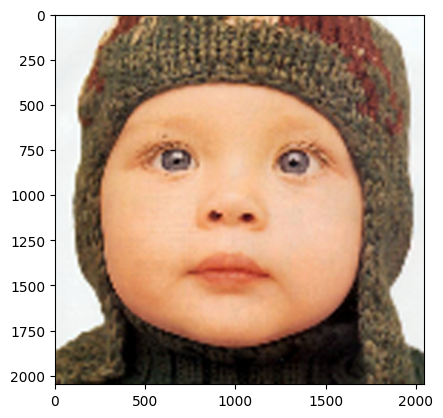

In [23]:
image_helper = ImageHelper()
image_helper.apply_model_to_image_and_show(
    model=netG,
    image=f"../datasets/Set5/baby.png",
    downsample_factor=4,
    unsqueeze=True
)

In [24]:
model_runner = ModelRunner(device=device)
model_runner.compare_models(
    [
        {"name": "SRGAN", "model": netG,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },
    ],
    f"../datasets/BSDS100/", scale=4
)

0it [00:00, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:61: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
100it [00:01, 80.13it/s]
100it [00:00, 100.08it/s]


,PSNR,SSIM
SRGAN,25.613373,0.681143
Bicubic,23.045410,0.632868


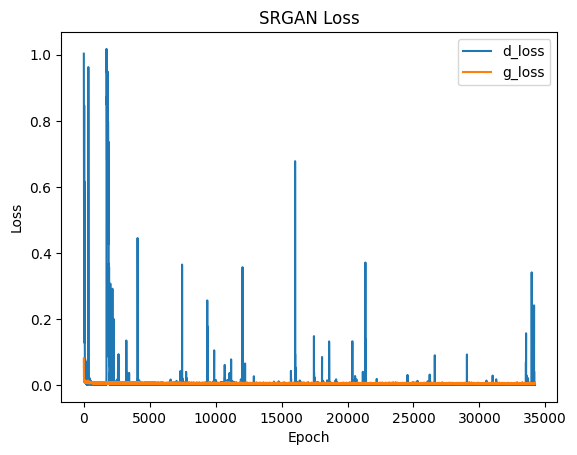

In [25]:
import matplotlib.pyplot as plt
# plot array
plt.plot(d_loss_array, label='d_loss')
plt.plot(g_loss_array, label='g_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SRGAN Loss')
plt.legend()
plt.show()


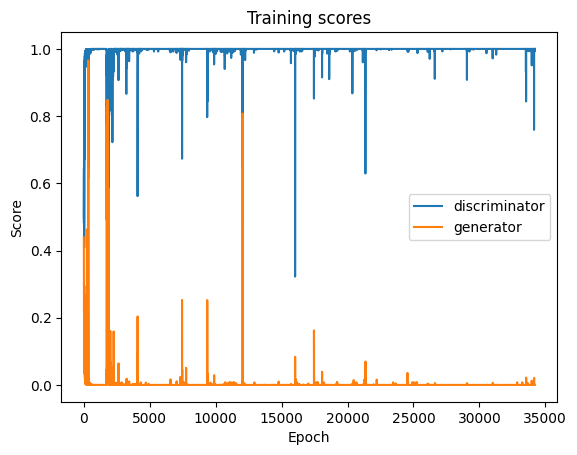

In [26]:
# plot scores
plt.plot(d_score_array, label='discriminator')
plt.plot(g_score_array, label='generator')
plt.legend()
plt.title('Training scores')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.show()

In [27]:
running_results

{'batch_sizes': 87539,
 'd_loss': 0.010298120190550986,
 'g_loss': 430.1875099418685,
 'd_score': 87538.99289017916,
 'g_score': 87538.99289017916}

In [30]:
# model_runner.save_model_weights(netG, '../results/srgan/trained_models/srgan_netG-50-epochs.pth')

In [31]:
netG_test = Generator(UPSCALE_FACTOR).to(device)
netG_test.load_state_dict(torch.load('../results/srgan/trained_models/srgan_netG-50-epochs.pth'))

<All keys matched successfully>

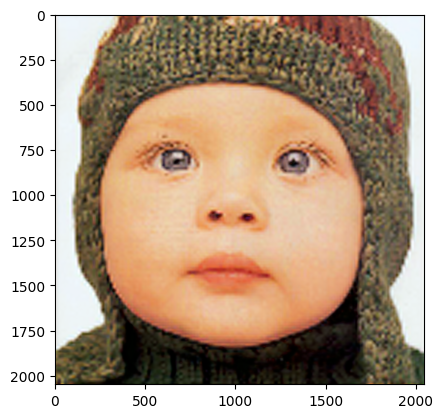

In [32]:
image_helper = ImageHelper()
image_helper.apply_model_to_image_and_show(
    model=netG_test,
    image=f"../datasets/Set5/baby.png",
    downsample_factor=4,
    unsqueeze=True
)